In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, GaussianNoise, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from datetime import datetime
from tqdm.notebook import tqdm
import random
import zipfile
from google.colab import drive, files
import time

In [3]:
# Kiểm tra GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Cố định seed
SEED = 1234
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
base_dir = '/content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/data'

In [6]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

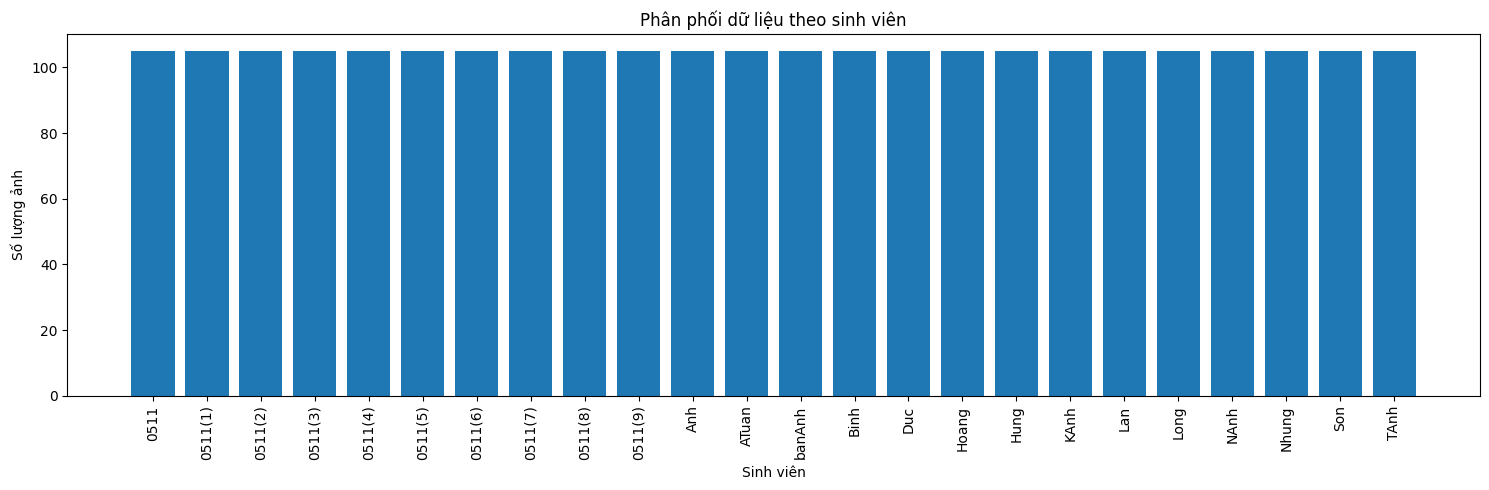

Số ảnh ít nhất: 105, nhiều nhất: 105


In [7]:
# Kiểm tra phân phối dữ liệu
student_counts = {}
for student_folder in os.listdir(train_dir):
    student_path = os.path.join(train_dir, student_folder)
    if os.path.isdir(student_path):
        images = [f for f in os.listdir(student_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        student_counts[student_folder] = len(images)

# Hiển thị phân phối
plt.figure(figsize=(15, 5))
plt.bar(student_counts.keys(), student_counts.values())
plt.xlabel('Sinh viên')
plt.ylabel('Số lượng ảnh')
plt.title('Phân phối dữ liệu theo sinh viên')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Nếu có sự mất cân bằng lớn, cân nhắc oversampling/undersampling
min_images = min(student_counts.values())
max_images = max(student_counts.values())
print(f"Số ảnh ít nhất: {min_images}, nhiều nhất: {max_images}")

In [8]:
# Kiểm tra cấu trúc dữ liệu
def check_data_structure(data_dir, type_name):
    if not os.path.exists(data_dir):
        print(f"Thư mục {type_name} không tồn tại: {data_dir}")
        return False

    class_dirs = os.listdir(data_dir)
    print(f"Thư mục {type_name} có {len(class_dirs)} lớp (sinh viên): {class_dirs}")

    total_images = 0
    class_distribution = {}

    for class_dir in class_dirs:
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            num_images = len(images)
            total_images += num_images
            class_distribution[class_dir] = num_images

    print(f"Tổng số ảnh trong {type_name}: {total_images}")
    print(f"Phân bố số lượng ảnh theo lớp: {class_distribution}\n")

    return True

In [9]:
train_ok = check_data_structure(train_dir, "train")
val_ok = check_data_structure(val_dir, "validation")
test_ok = check_data_structure(test_dir, "test")

Thư mục train có 24 lớp (sinh viên): ['0511', '0511(1)', '0511(2)', '0511(3)', '0511(4)', '0511(5)', '0511(6)', '0511(7)', '0511(8)', '0511(9)', 'Anh', 'ATuan', 'banAnh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh']
Tổng số ảnh trong train: 2520
Phân bố số lượng ảnh theo lớp: {'0511': 105, '0511(1)': 105, '0511(2)': 105, '0511(3)': 105, '0511(4)': 105, '0511(5)': 105, '0511(6)': 105, '0511(7)': 105, '0511(8)': 105, '0511(9)': 105, 'Anh': 105, 'ATuan': 105, 'banAnh': 105, 'Binh': 105, 'Duc': 105, 'Hoang': 105, 'Hung': 105, 'KAnh': 105, 'Lan': 105, 'Long': 105, 'NAnh': 105, 'Nhung': 105, 'Son': 105, 'TAnh': 105}

Thư mục validation có 24 lớp (sinh viên): ['0511', '0511(1)', '0511(2)', '0511(3)', '0511(4)', '0511(5)', '0511(6)', '0511(7)', '0511(8)', '0511(9)', 'Anh', 'ATuan', 'banAnh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh']
Tổng số ảnh trong validation: 552
Phân bố số lượng ảnh theo lớp: {'0511': 23

In [10]:
# Cấu hình tham số
IMG_SIZE = 448
BATCH_SIZE = 32
EPOCHS = 300

In [11]:
# Tạo danh sách các lớp (mỗi lớp là một sinh viên)
classes = sorted(os.listdir(train_dir))
num_classes = len(classes)

print(f"Số lượng lớp: {num_classes}")
print(f"Các lớp: {classes}")

Số lượng lớp: 24
Các lớp: ['0511', '0511(1)', '0511(2)', '0511(3)', '0511(4)', '0511(5)', '0511(6)', '0511(7)', '0511(8)', '0511(9)', 'ATuan', 'Anh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh', 'banAnh']


In [12]:
# Data augmentation cho tập huấn luyện
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=0.1,
    fill_mode='nearest'
)

# Chỉ rescale cho tập validation và test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2520 images belonging to 24 classes.
Found 552 images belonging to 24 classes.
Found 528 images belonging to 24 classes.


In [14]:
# Tính toán class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Tính toán class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0), 7: np.float64(1.0), 8: np.float64(1.0), 9: np.float64(1.0), 10: np.float64(1.0), 11: np.float64(1.0), 12: np.float64(1.0), 13: np.float64(1.0), 14: np.float64(1.0), 15: np.float64(1.0), 16: np.float64(1.0), 17: np.float64(1.0), 18: np.float64(1.0), 19: np.float64(1.0), 20: np.float64(1.0), 21: np.float64(1.0), 22: np.float64(1.0), 23: np.float64(1.0)}


In [15]:
def show_batch(image_batch, label_batch, class_indices):
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    plt.figure(figsize=(10, 10))
    for i in range(min(25, len(image_batch))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i])

        # Lấy index của lớp được dự đoán (argmax)
        class_idx = np.argmax(label_batch[i])
        class_name = idx_to_class[class_idx]

        plt.title(class_name, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [16]:
images, labels = next(train_generator)

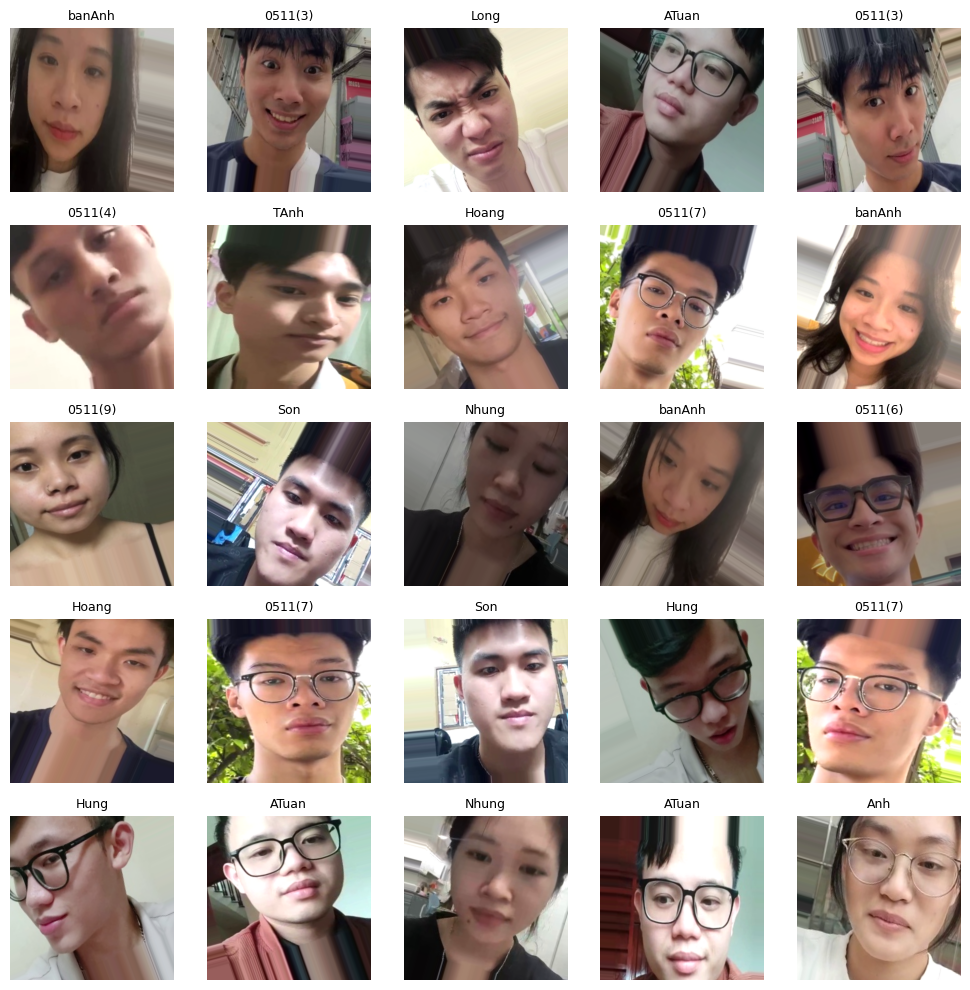

In [17]:
show_batch(images, labels, train_generator.class_indices)

In [18]:
# def simple_lr_finder(model, train_generator, min_lr=1e-6, max_lr=1e-2, epochs=1, batch_size=32):
#     """
#     Phương pháp đơn giản để tìm learning rate phù hợp - phiên bản TF 2.x
#     """
#     # Lưu trọng số ban đầu
#     initial_weights = model.get_weights()

#     # Tính số bước trên mỗi epoch
#     steps = len(train_generator)

#     # Tính tổng số bước
#     total_steps = steps * epochs

#     # Khởi tạo danh sách để lưu learning rate và loss
#     lrs = []
#     losses = []

#     # Tính hệ số nhân cho mỗi bước
#     lr_multiplier = (max_lr / min_lr) ** (1 / total_steps)

#     # Thiết lập learning rate ban đầu
#     current_lr = min_lr

#     print("Bắt đầu tìm learning rate tối ưu...")

#     # Chạy một epoch để tìm learning rate
#     for epoch in range(epochs):
#         for batch_idx, (x_batch, y_batch) in enumerate(train_generator):
#             # Tạo optimizer mới với learning rate hiện tại
#             model.optimizer.learning_rate = current_lr

#             # Huấn luyện một batch
#             loss = model.train_on_batch(x_batch, y_batch)[0]

#             # Lưu learning rate và loss
#             lrs.append(current_lr)
#             losses.append(loss)

#             # Tăng learning rate cho batch tiếp theo
#             current_lr *= lr_multiplier

#             # In thông tin
#             if batch_idx % 10 == 0:
#                 print(f"Batch {batch_idx}/{steps}, LR: {current_lr:.6f}, Loss: {loss:.4f}")

#             # Nếu loss tăng đột biến hoặc NaN, dừng lại
#             if not np.isfinite(loss) or (len(losses) > 1 and loss > 4 * losses[0]):
#                 print("Loss tăng đột biến, dừng tìm kiếm!")
#                 break

#             # Nếu đã đủ số bước, dừng lại
#             if batch_idx + 1 >= steps:
#                 break

#     # Khôi phục trọng số ban đầu
#     model.set_weights(initial_weights)

#     # Vẽ biểu đồ
#     plt.figure(figsize=(10, 6))
#     plt.plot(lrs, losses)
#     plt.xscale('log')
#     plt.xlabel('Learning rate')
#     plt.ylabel('Loss')
#     plt.title('Learning Rate vs. Loss')
#     plt.grid(True)
#     plt.show()

#     # Tìm learning rate tại điểm loss giảm nhanh nhất
#     smooth_losses = []
#     for i in range(len(losses)):
#         if i < 5:
#             smooth_losses.append(np.mean(losses[:i+1]))
#         else:
#             smooth_losses.append(np.mean(losses[i-5:i+1]))

#     # Tính gradient
#     gradients = np.gradient(smooth_losses)

#     # Loại bỏ những điểm đầu tiên vì thường không ổn định
#     start_idx = min(10, len(gradients) // 5)

#     # Tìm điểm có gradient âm lớn nhất sau các điểm đầu tiên
#     min_gradient_idx = start_idx + np.argmin(gradients[start_idx:])

#     # Tìm learning rate tại điểm có gradient âm lớn nhất
#     if min_gradient_idx < len(lrs):
#         optimal_lr = lrs[min_gradient_idx]
#     else:
#         # Nếu có vấn đề với index, sử dụng giá trị an toàn
#         optimal_lr = min_lr * 1000  # Giá trị giữa min_lr và max_lr

#     # Learning rate an toàn
#     safe_lr = optimal_lr / 10

#     print(f"Learning rate với gradient âm lớn nhất: {optimal_lr:.6f}")
#     print(f"Learning rate an toàn (1/10): {safe_lr:.6f}")

#     return optimal_lr, safe_lr

In [19]:
def build_model(num_classes):
    # Tạo input layer
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Thêm Gaussian noise ngay sau input
    x = GaussianNoise(0.1)(inputs)

    # Tải MobileNetV2 pre-trained trên ImageNet, không bao gồm lớp fully connected
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Đóng băng các lớp của mô hình cơ sở
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    # Thêm các lớp mới
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)

    # Lớp output cho nhận diện khuôn mặt (số lượng lớp = số sinh viên)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Tạo model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model, base_model

In [20]:
# Tạo mô hình
model, base_model = build_model(num_classes)

<ipython-input-19-c732a5fc0df1>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# # Compile model với learning rate tạm thời
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

In [22]:
# optimal_lr, safe_lr = simple_lr_finder(
#     model,
#     train_generator,
#     min_lr=1e-7,
#     max_lr=10,
#     epochs=1,
#     batch_size=BATCH_SIZE
# )

In [23]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 448, 448,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 224, 224,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 224, 224,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 224, 224,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 224, 224,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 224, 224,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 224, 224,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 224, 224,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 224, 224,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 224, 224,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 224, 224,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 224, 224,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 225, 225,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 112, 112,  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 112, 112,  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 112, 112,  │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 112, 112,  │      2,304 │ block_1_depthwis

 Total params: 4,111,960 (15.69 MB)

 Trainable params: 2,583,896 (9.86 MB)

 Non-trainable params: 1,528,064 (5.83 MB)

## Huấn luyện mô hình - Giai đoạn 1: Train lớp top

In [26]:
# Thư mục để lưu mô hình
model_dir = '/content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models'
os.makedirs(model_dir, exist_ok=True)

In [27]:
# Tạo tên mô hình với timestamp
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = f"face_recognition_model_{timestamp}"
model_path = os.path.join(model_dir, model_name)
os.makedirs(model_path, exist_ok=True)

In [28]:
# Callbacks
checkpoint = ModelCheckpoint(
    os.path.join(model_path, 'best_model_stage1.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

tensorboard = TensorBoard(
    log_dir=os.path.join(model_path, 'logs'),
    histogram_freq=1
)

callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard]

In [29]:
# Tính số bước trên mỗi epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

In [ ]:
# Huấn luyện model - Giai đoạn 1 (chỉ train các lớp top mới thêm vào)
start = time.time()
history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
74/78 ━━━━━━━━━━━━━━━━━━━━ 53s 13s/step - accuracy: 0.1986 - loss: 3.0493 

## Fine-tuning - Giai đoạn 2: Tinh chỉnh một số lớp của mô hình cơ sở

In [ ]:
# Mở khóa các lớp cuối của base model
# Đóng băng các lớp đầu, mở khóa các lớp cuối để fine-tune
for layer in base_model.layers[:-30]:  # Giữ các lớp đầu đóng băng
    layer.trainable = False
for layer in base_model.layers[-30:]:  # Mở khóa 40 lớp cuối
    layer.trainable = True

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Learning rate thấp hơn cho fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Cập nhật callbacks cho giai đoạn 2
checkpoint_stage2 = ModelCheckpoint(
    os.path.join(model_path, 'best_model_stage2.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks_stage2 = [checkpoint_stage2, early_stopping, reduce_lr, tensorboard]

In [ ]:
# Huấn luyện giai đoạn 2 - Fine-tuning
history_stage2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=200,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_stage2,
    class_weight=class_weight_dict,
    verbose=1
)

end = time.time()
print(f"Thời gian huấn luyện: {end - start:.2f} giây")

## 8. Đánh giá mô hình trên tập test

In [ ]:
# Tải model tốt nhất
best_model_path = os.path.join(model_path, 'best_model_stage2.h5')
model = load_model(best_model_path)

In [ ]:
# Đánh giá trên tập test
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

In [ ]:
# Dự đoán trên tập test
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Lấy nhãn thực tế
test_labels = test_generator.classes[:len(y_pred_classes)]

# In báo cáo phân loại
class_names = list(test_generator.class_indices.keys())
print("Classification Report:\n")
print(classification_report(test_labels, y_pred_classes, target_names=class_names))

In [ ]:
# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_labels, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Hiển thị các kết quả dự đoán

In [ ]:
def show_prediction_examples(test_generator, model, class_indices, num_examples=10):
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Reset generator
    test_generator.reset()

    # Lấy các batch cho đến khi đủ số lượng ví dụ
    examples = []
    count = 0

    for i in range(min(50, len(test_generator))):
        if count >= num_examples:
            break

        x_batch, y_batch = next(test_generator)
        y_pred_batch = model.predict(x_batch)

        for j in range(len(x_batch)):
            if count >= num_examples:
                break

            true_class_idx = np.argmax(y_batch[j])
            pred_class_idx = np.argmax(y_pred_batch[j])
            confidence = y_pred_batch[j][pred_class_idx]

            is_correct = true_class_idx == pred_class_idx

            examples.append({
                'image': x_batch[j],
                'true_class': idx_to_class[true_class_idx],
                'pred_class': idx_to_class[pred_class_idx],
                'confidence': confidence,
                'is_correct': is_correct
            })

            count += 1

    # Hiển thị các ví dụ
    plt.figure(figsize=(15, 4 * num_examples//5 + 4))

    for i, example in enumerate(examples):
        ax = plt.subplot(num_examples//5 + 1, 5, i + 1)

        plt.imshow(example['image'])

        title_color = 'green' if example['is_correct'] else 'red'
        plt.title(
            f"True: {example['true_class']}\nPred: {example['pred_class']}\nConf: {example['confidence']:.2f}",
            color=title_color,
            fontsize=9
        )

        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
show_prediction_examples(test_generator, model, test_generator.class_indices, num_examples=50)

In [ ]:
def show_incorrect_predictions(test_generator, model, class_indices, num_examples=15):
    """
    Hiển thị các ví dụ dự đoán sai từ tập test

    Args:
        test_generator: Generator cho tập test
        model: Mô hình đã huấn luyện
        class_indices: Dictionary ánh xạ tên lớp thành index
        num_examples: Số lượng ví dụ sai muốn hiển thị
    """
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Reset generator
    test_generator.reset()

    # Danh sách lưu các dự đoán sai
    incorrect_examples = []

    # Duyệt qua tập test để tìm các dự đoán sai
    for i in range(len(test_generator)):
        x_batch, y_batch = next(test_generator)
        y_pred_batch = model.predict(x_batch)

        for j in range(len(x_batch)):
            true_class_idx = np.argmax(y_batch[j])
            pred_class_idx = np.argmax(y_pred_batch[j])

            # Kiểm tra nếu dự đoán sai
            if true_class_idx != pred_class_idx:
                confidence = y_pred_batch[j][pred_class_idx]

                incorrect_examples.append({
                    'image': x_batch[j],
                    'true_class': idx_to_class[true_class_idx],
                    'pred_class': idx_to_class[pred_class_idx],
                    'confidence': confidence
                })

                # Nếu đã đủ số lượng ví dụ, dừng vòng lặp
                if len(incorrect_examples) >= num_examples:
                    break

        # Nếu đã đủ số lượng ví dụ, dừng vòng lặp
        if len(incorrect_examples) >= num_examples:
            break

    if not incorrect_examples:
        print("Không có dự đoán sai nào được tìm thấy trong tập test!")
        return

    total_found = len(incorrect_examples)
    print(f"Tìm thấy {total_found} dự đoán sai. Hiển thị tối đa {min(num_examples, total_found)} ví dụ:")

    # Hiển thị các ví dụ sai
    rows = (min(num_examples, total_found) // 3) + (1 if min(num_examples, total_found) % 3 > 0 else 0)
    plt.figure(figsize=(15, 5 * rows))

    for i, example in enumerate(incorrect_examples[:num_examples]):
        ax = plt.subplot(rows, 3, i + 1)

        plt.imshow(example['image'])

        plt.title(
            f"True: {example['true_class']}\nPred: {example['pred_class']}\nConf: {example['confidence']:.2f}",
            color='red',
            fontsize=10
        )

        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Thực thi hàm để hiển thị các dự đoán sai
print("Hiển thị các dự đoán sai trên tập test:")
show_incorrect_predictions(test_generator, model, test_generator.class_indices, num_examples=15)

## Vẽ đồ thị quá trình huấn luyện

In [ ]:
def plot_training_history(history1, history2=None, title="Training History"):
    plt.figure(figsize=(15, 5))

    # Đồ thị accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Stage 1 Train')
    plt.plot(history1.history['val_accuracy'], label='Stage 1 Validation')


    # Tiếp tục từ đoạn code trước
    if history2:
        # Xác định điểm bắt đầu của stage 2
        stage1_epochs = len(history1.history['accuracy'])
        x_stage2 = range(stage1_epochs, stage1_epochs + len(history2.history['accuracy']))

        plt.plot(x_stage2, history2.history['accuracy'], label='Stage 2 Train')
        plt.plot(x_stage2, history2.history['val_accuracy'], label='Stage 2 Validation')

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Đồ thị loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Stage 1 Train')
    plt.plot(history1.history['val_loss'], label='Stage 1 Validation')

    if history2:
        plt.plot(x_stage2, history2.history['loss'], label='Stage 2 Train')
        plt.plot(x_stage2, history2.history['val_loss'], label='Stage 2 Validation')

    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

In [ ]:
plot_training_history(history_stage1, history_stage2, "Face Recognition Model Training History")

In [ ]:
import pickle
with open(os.path.join(model_path, 'history.pkl'), 'wb') as f:
    pickle.dump({
        'stage1': history_stage1.history,
        'stage2': history_stage2.history
    }, f)

In [ ]:
import tensorflow as tf

# Bước 1: Load mô hình .h5
model = tf.keras.models.load_model(best_model_path)

# Bước 2: Chuyển sang định dạng TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Bước 3: Lưu lại file .tflite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("Chuyển đổi thành công!")

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# def visualize_feature_maps(model, img_path, layer_name=None, num_filters=64, size=8):
#     """
#     Trực quan hóa feature maps từ một lớp cụ thể của mô hình khi đầu vào là một ảnh

#     Args:
#         model: Mô hình đã huấn luyện
#         img_path: Đường dẫn đến ảnh đầu vào
#         layer_name: Tên của lớp cần trực quan hóa (nếu None, sẽ hiển thị danh sách các lớp)
#         num_filters: Số lượng filters tối đa để hiển thị
#         size: Kích thước hình vuông để hiển thị feature maps (ví dụ: 8x8=64 feature maps)
#     """
#         # Hiển thị danh sách các lớp nếu không chỉ định layer_name
#     if layer_name is None:
#         for i, layer in enumerate(model.layers):
#             # Lấy thông tin shape một cách an toàn
#             try:
#                 if hasattr(layer, 'output_shape'):
#                     shape_info = str(layer.output_shape)
#                 elif hasattr(layer, 'output'):
#                     shape_info = str(layer.output.shape)
#                 else:
#                     shape_info = "Shape không khả dụng"
#             except:
#                 shape_info = "Không thể xác định shape"

#             print(f"{i}: {layer.name}, Type: {layer.__class__.__name__}, Shape: {shape_info}")
#         return

#     # Tạo mô hình mới lấy đầu ra từ lớp được chỉ định
#     layer_output = model.get_layer(layer_name).output
#     activation_model = Model(inputs=model.input, outputs=layer_output)

#     # Tải và xử lý ảnh đầu vào
#     img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
#     img_tensor = img_to_array(img)
#     img_tensor = img_tensor / 255.0  # Chuẩn hóa
#     img_tensor = np.expand_dims(img_tensor, axis=0)  # Thêm batch dimension

#     # Lấy activations
#     activations = activation_model.predict(img_tensor)

#     # Tính toán số cột, số hàng để hiển thị
#     n_features = activations.shape[-1]
#     n_features = min(n_features, num_filters)  # Giới hạn số lượng filters hiển thị

#     # Tính số hàng và cột cần thiết
#     size = min(size, int(np.ceil(np.sqrt(n_features))))
#     cols = size
#     rows = int(np.ceil(n_features / cols))

#     # Hiển thị ảnh gốc
#     plt.figure(figsize=(12, 12))
#     plt.subplot(rows + 1, cols, 1)
#     plt.imshow(img)
#     plt.title('Original Image')
#     plt.axis('off')

#     # Hiển thị feature maps
#     for i in range(n_features):
#         plt.subplot(rows + 1, cols, i + cols + 1)
#         feature_map = activations[0, :, :, i]

#         # Chuẩn hóa feature map để hiển thị
#         feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min() + 1e-7)

#         plt.imshow(feature_map, cmap='viridis')
#         plt.title(f'Filter {i}')
#         plt.axis('off')

#     plt.suptitle(f'Feature Maps from {layer_name}')
#     plt.tight_layout()
#     plt.show()

# # Hàm trực quan hóa nhiều lớp cùng một lúc
# def visualize_multiple_layers(model, img_path, layer_names=None, filters_per_layer=16):
#     """
#     Trực quan hóa feature maps từ nhiều lớp của mô hình

#     Args:
#         model: Mô hình đã huấn luyện
#         img_path: Đường dẫn đến ảnh đầu vào
#         layer_names: Danh sách tên các lớp cần trực quan hóa
#         filters_per_layer: Số filters hiển thị cho mỗi lớp
#     """
#     # Nếu không có danh sách lớp, chọn một số lớp đại diện
#     if layer_names is None:
#         # Tự động chọn các lớp conv đại diện từ đầu, giữa và cuối mạng
#         conv_layers = [layer.name for layer in model.layers if 'conv' in layer.name.lower()]
#         layer_names = []
#         if len(conv_layers) >= 3:
#             # Lấy layer ở đầu, giữa và cuối
#             layer_names = [
#                 conv_layers[0],
#                 conv_layers[len(conv_layers) // 2],
#                 conv_layers[-1]
#             ]
#         else:
#             layer_names = conv_layers

#     # Tải và xử lý ảnh đầu vào
#     img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
#     img_tensor = img_to_array(img)
#     img_tensor = img_tensor / 255.0
#     img_tensor = np.expand_dims(img_tensor, axis=0)

#     # Hiển thị ảnh gốc
#     plt.figure(figsize=(12, 5 * len(layer_names)))
#     plt.subplot(len(layer_names) + 1, 1, 1)
#     plt.imshow(img)
#     plt.title('Original Image')
#     plt.axis('off')

#     # Hiển thị feature maps cho từng lớp
#     for i, layer_name in enumerate(layer_names):
#         try:
#             # Tạo mô hình lấy đầu ra từ layer này
#             layer_output = model.get_layer(layer_name).output
#             activation_model = Model(inputs=model.input, outputs=layer_output)

#             # Lấy activations
#             activations = activation_model.predict(img_tensor)

#             # Xác định số hàng, cột cho subplot
#             n_features = min(filters_per_layer, activations.shape[-1])
#             cols = 8
#             rows = int(np.ceil(n_features / cols))

#             # Tạo tiêu đề cho layer
#             plt.subplot(len(layer_names) + 1, 1, i + 2)
#             plt.title(f"Feature maps from layer: {layer_name} (showing {n_features}/{activations.shape[-1]} filters)")
#             plt.axis('off')

#             # Tạo một figure mới cho layer này
#             plt.figure(figsize=(16, 2 * rows))
#             plt.suptitle(f"Feature maps from layer: {layer_name} (shape: {activations.shape[1:]}, showing {n_features}/{activations.shape[-1]} filters)")

#             # Hiển thị các feature map
#             for j in range(n_features):
#                 plt.subplot(rows, cols, j + 1)
#                 feature_map = activations[0, :, :, j]

#                 # Chuẩn hóa để hiển thị
#                 if feature_map.max() > feature_map.min():
#                     feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())

#                 plt.imshow(feature_map, cmap='viridis')
#                 plt.title(f'Filter {j}')
#                 plt.axis('off')

#             plt.tight_layout()
#             plt.show()

#         except Exception as e:
#             print(f"Không thể trực quan hóa lớp {layer_name}: {e}")

# # Sử dụng:
# # 1. Hiển thị danh sách các lớp trong mô hình
# visualize_feature_maps(model, None)

# # 2. Trực quan hóa feature maps từ một lớp cụ thể
# # Thay 'path_to_test_image.jpg' bằng đường dẫn đến ảnh test
# image_path = '/content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/data/test/ATuan/segment_00_frame_01.jpg'
# # Thay 'conv_dw_1' bằng tên lớp bạn muốn trực quan hóa (lấy từ kết quả bước 1)
# visualize_feature_maps(model, image_path, layer_name='expanded_conv_depthwise', num_filters=32)

# # 3. Trực quan hóa feature maps từ nhiều lớp
# # Bạn có thể chỉ định danh sách lớp hoặc để hàm tự động chọn
# visualize_multiple_layers(model, image_path)

# # 4. Chỉ định các lớp cụ thể để trực quan hóa
# early_layer = 'block_1_expand'  # Layer đầu
# middle_layer = 'block_10_expand'  # Layer giữa
# late_layer = 'Conv_1'  # Layer cuối
# visualize_multiple_layers(model, image_path, layer_names=[early_layer, middle_layer, late_layer])